In [184]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy

In [118]:
# basic algorithm dev cell

#nxd
patterns = np.array([[-1,-1,1,-1,1,-1,-1,1],[-1,-1,-1,-1,-1,1,-1,-1],[-1,1,1,-1,-1,1,-1,1]])

#dxd
weights = np.dot(patterns.T,patterns)
print(weights.shape)

def update(patterns, weights):
    
    x = np.dot(weights, patterns.T)
    x = (x>=0)*1
    x = np.where(x==0, -1, x)
    #print(x)
    return x.T
#nxd
patterns = update(patterns, weights)
print(patterns.shape)


# task 3.1
x1d = [1,-1,1,-1,1,-1,-1,1]
x2d = [1,-1,-1,-1,-1,1,-1,-1]
x3d = [1,1,1,-1,1,1,-1,1]
xd = np.array([x1d,x2d,x3d])
print(xd.shape)

x1d = np.array([1,-1,1,-1,1,-1,-1,1])
x2d = np.array([1,-1,-1,-1,-1,1,-1,-1])
x3d = np.array([1,1,1,-1,1,1,-1,1])

for cnt, i in enumerate(x3d):
    print(cnt)

(8, 8)
(3, 8)
(3, 8)
0
1
2
3
4
5
6
7


In [193]:
# class definition

class hopfield_network():
    """
    A class for applying hopfield networks, via synchronous or sequential updates.
    
    Inputs:
    patterns = the patterns (nxd) you wish to memorise
    update_rule = 'synchronous' or 'sequential'
    
    Methods:
    recall - reconstructs a pattern from a given distorted pattern
    attractor_search - random sampling based search for attractors
    attractor_search2 - search for attractors by systematically trying each possible distorted pattern
    
    Returns:
    hopfield_network object
    
    """
    
    def __init__(self, patterns, update_rule = 'synchronous'):
        
        self.patterns = patterns
        self.weights = np.dot(patterns.T,patterns)
        #print(self.weights.shape)
        self.update_rule = update_rule
        self.check_capacity()
        
    
    def check_capacity(self): 
    # checks whether input patterns are stable / fixed points
        
        #x = self.update(patterns=self.patterns)
        x = np.dot(self.weights, self.patterns.T)
        x = (x>=0)*1
        x = np.where(x==0, -1, x)
        assert (x.T == self.patterns).all(), """The network cannot store all these patterns! Ie patterns are not stable/fixed points!"""
    
    def update(self, patterns): 
    # learning rule
        
        if self.update_rule=='synchronous':
            x = np.dot(self.weights, patterns.T)
            x = (x>=0)*1
            x = np.where(x==0, -1, x)
            #print(x)
            return x.T
        
        if self.update_rule=='sequential':
            
            y = copy.deepcopy(patterns)
            
            for cnt,i in enumerate(self.weights):
                x_i = np.dot(i, y.T)
                x_i = (x_i>=0)*1
                x_i = np.where(x_i==0, -1, x_i)
                #print(x_i)
                y[cnt] = x_i
            
            return y
            
            
            
    
    def recall(self, distorted_patterns, max_iter): 
    # 1. tries to find stored patterns from distorted patterns up to max_iter times
    # 2. stops if fixed point is reached or pattern is correctly recalled
        
        x = copy.deepcopy(distorted_patterns)
        
        for i in range(max_iter):
            
            x_new = self.update(x)
            
            
#             if (x_new==self.patterns).all():
#                 print('Patterns recalled after {} iterations'.format(i+1))
#                 #print('Distorted Patterns:\n',x_new)
#                 #print('Stored Patterns:\n',self.patterns)
#                 break
                
            if (x_new==x).all():
                print('Fixed point reached after {} iterations'.format(i+1))
                #print('Distorted Patterns:\n',x_new)
                #print('Stored Patterns:\n',self.patterns)
                break
            
            x = x_new
        
        # returns the last found pattern - either a fixed point or an original pattern
        # compare it to the original patterns to which it is
        return x_new
            
    def attractor_search(self, max_bit_error = 3, search_iter = 100):
        # 1. changes stored patterns randomly by up to max_bit_error bits
        # 2. then tries to converge to the original stored pattern again
        # 3. keeps count of how many different convergence points there are (ie num of attractors)
        # 4. returns number of attractors
        
        convergence_points = []
        
        for j in range(search_iter):
            base_pattern_idx = np.random.choice(np.arange(self.patterns.shape[0])) # chooses one of n stored patterns to distort
            x = self.patterns[base_pattern_idx] # x var is our soon to be distorted pattern
            
            # distort pattern
            for i in range(max_bit_error):
                flip = np.random.choice([-1,1])
                loc = np.random.choice(np.arange(self.weights.shape[1]))
                x[loc] = flip
            
            
            # try to find original pattern - maybe change max_iter here if more complex patterns and datasets
            x_new = self.recall(x, max_iter = 50)
            convergence_points.append(x_new)
        
        #print('CONVERGENCE POINTS:\n',np.vstack(convergence_points))
        attractors = np.unique(np.vstack(convergence_points), axis=0)
        
        print('These are the attractors:\n',attractors)
        
        
        #return num of attractors
        return attractors.shape[0]
    
    def attractor_search2(self):
        # 1. create all possible distorted signals - d^2
        # 2. then try to recall a pattern from each
        # 3. count of how many different convergence points there are (ie num of attractors)
        
        convergence_points = []
        
        # 1.
        d = np.arange(2**(self.weights.shape[0]))
        m = self.weights.shape[0]
        all_signals = (((d[:,None] & (1 << np.arange(m)))) > 0).astype(int) #all signals as binary
        print(all_signals.shape)
        all_signals = np.where(all_signals==0, -1, all_signals)
        
        
        for i in range(2**(self.weights.shape[0])):
            # 2. 
            x_new = self.recall(all_signals[i], max_iter=50)
            convergence_points.append(x_new)
        # 3.
        attractors = np.unique(np.vstack(convergence_points), axis=0)
        print('These are the attractors:\n',attractors)
        
        
        #return num of attractors
        return attractors.shape[0]
            
            
            
        
        
                
            
            
                
                
    

In [48]:
# Task 3.1

task = hopfield_network(patterns)
x_new1 = task.recall(x1d,10000) # ANSWER Q3.1a): Fixed point reached after 2 or 3 iter, with all distorted patterns converging.
x_new2 = task.recall(x2d,10000) # if you try recall all 3 simultaneously, x2d does not converge
x_new3 = task.recall(x3d,10000)
print(x_new1)
print(x_new2)
print(x_new3)
print('Original Patterns\n',patterns)

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
[-1 -1  1 -1  1 -1 -1  1]
[-1 -1 -1 -1 -1  1 -1 -1]
[-1  1  1 -1 -1  1 -1  1]
Original Patterns
 [[-1 -1  1 -1  1 -1 -1  1]
 [-1 -1 -1 -1 -1  1 -1 -1]
 [-1  1  1 -1 -1  1 -1  1]]


In [49]:
task.attractor_search(max_bit_error = 3, search_iter = 100000) #attractor search uses random sampling

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after

These are the attractors:
 [[-1 -1 -1 -1 -1  1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1  1 -1 -1  1 -1  1]
 [-1 -1  1 -1  1 -1 -1  1]
 [-1 -1  1 -1  1  1 -1  1]
 [-1  1 -1 -1 -1  1 -1 -1]
 [-1  1  1 -1 -1  1 -1  1]
 [-1  1  1 -1  1 -1 -1  1]
 [ 1 -1 -1  1  1 -1  1 -1]
 [ 1  1 -1  1 -1  1  1 -1]
 [ 1  1 -1  1  1 -1  1 -1]
 [ 1  1 -1  1  1  1  1 -1]
 [ 1  1  1  1 -1  1  1  1]
 [ 1  1  1  1  1 -1  1  1]]


14

In [50]:
task.attractor_search2() # attractor search 2 computes all possible configurations and runs them - it's better

(256, 8)
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 1 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reac

14

In [ ]:
# ANSWER: Q3.1b) we found 14 different fixed points/attractors 

In [109]:
# Task 3.1c) 
# ANSWER: If we change more than half of the bits, the original patterns are not recalled.

x1d = np.array([1,1,-1,-1,1,1,1,-1])
x2d = np.array([1,1,1,-1,-1,-1,1,-1])
x3d = np.array([1,1,1,1,1,1,1,-1])

task = hopfield_network(patterns)
x_new1 = task.recall(x1d,10000) 
x_new2 = task.recall(x2d,10000)
x_new3 = task.recall(x3d,10000)
print(x_new1)
print(x_new2)
print(x_new3)
print('Original Patterns\n',patterns)

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
[ 1  1 -1 -1  1  1  1  1]
[ 1  1  1 -1 -1 -1  1  1]
[ 1  1 -1  1  1  1  1  1]
Original Patterns
 [[-1 -1 -1  1  1  1 -1 -1]
 [-1 -1  1 -1 -1 -1  1 -1]
 [-1 -1  1  1 -1 -1 -1 -1]]


In [51]:
# Task 3.2
import os

cwd = os.getcwd()
path_to_data = cwd + '\\pict.dat'
 #look at data
f = open(path_to_data, "r")
print(f.read())

-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,

In [126]:
#load and format data
pictures = np.genfromtxt(path_to_data,delimiter=',')
pictures = pictures.reshape(11,1024)
p1 = pictures[0]
p2 = pictures[1]
p3 = pictures[2]
p4 = pictures[3]
p5 = pictures[4]
p6 = pictures[5]
p7 = pictures[6]
p8 = pictures[7]
p9 = pictures[8]
p10 = pictures[9]
p11 = pictures[10]

In [164]:
# apply a hopfield network and stuff
# task 3.2a) : ANSWER: indeed, the three patterns are stable
task = hopfield_network(pictures[0:3]) 

In [165]:
recalled_p10 = task.recall(p10, max_iter=100)

Fixed point reached after 2 iterations


In [166]:
#visualise
def visualise_pattern(original_pattern, distorted_pattern, recalled_pattern, image_shape=(32,32)):
    fig = plt.figure()
    fig.suptitle('Effects of hopfield network',y=0.8)
    ax1 = fig.add_subplot(131)
    ax1.imshow(original_pattern.reshape(image_shape), interpolation='nearest', cmap=cm.Greys_r)
    ax1.title.set_text('Original Pattern')
    ax2 = fig.add_subplot(132)
    ax2.imshow(distorted_pattern.reshape(image_shape), interpolation='nearest', cmap=cm.Greys_r)
    ax2.title.set_text('Degraded')
    ax3 = fig.add_subplot(133)
    ax3.imshow(recalled_pattern.reshape(image_shape), interpolation='nearest', cmap=cm.Greys_r)
    ax3.title.set_text('Reconstructed')
    
    

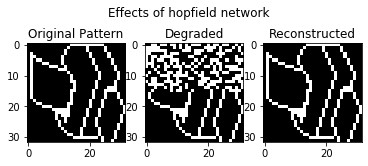

In [167]:
#task 3.2b)
visualise_pattern(p1,p10,recalled_p10) 

In [168]:
recalled_p11 = task.recall(p11, max_iter=100)

Fixed point reached after 3 iterations


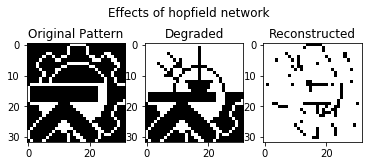

In [169]:
#task 3.2b)
visualise_pattern(p2,p11,recalled_p11)

In [170]:
#task 3.2b)
visualise_pattern(p3,p11,recalled_p11)

In [171]:
# task 3.2c) I think we're being asked to generate random patterns and then see what is recalled.
# And then implement sequential update and do the same
# We should expect sequential to find better solutions, but compute longer

In [172]:
def visualise_random_pattern(original_patterns, distorted_pattern, recalled_pattern, image_shape=(32,32)):
    fig = plt.figure(figsize=(16,5))
    fig.suptitle('Effects of hopfield network',y=0.8)
    ax1 = fig.add_subplot(1,original_patterns.shape[0]+2,1)
    ax1.imshow(distorted_pattern.reshape(image_shape), interpolation='nearest', cmap=cm.Greys_r)
    ax1.title.set_text('Random')
    ax2 = fig.add_subplot(1,original_patterns.shape[0]+2,2)
    ax2.imshow(recalled_pattern.reshape(image_shape), interpolation='nearest', cmap=cm.Greys_r)
    ax2.title.set_text('Reconstruction')
    for i in range(original_patterns.shape[0]):
        ax3 = fig.add_subplot(1,original_patterns.shape[0]+2,i+3)
        ax3.imshow(original_patterns[i].reshape(image_shape), interpolation='nearest', cmap=cm.Greys_r)
        

Fixed point reached after 3 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 3 iterations


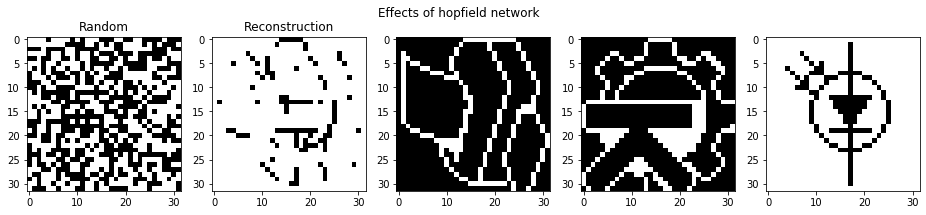

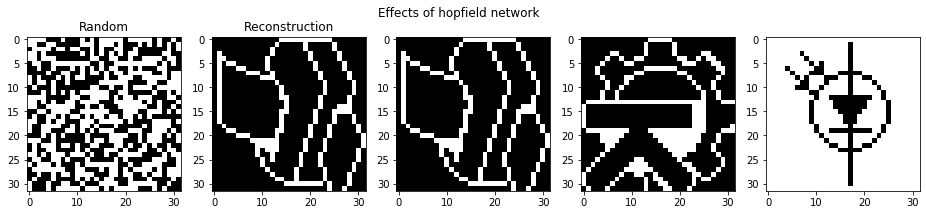

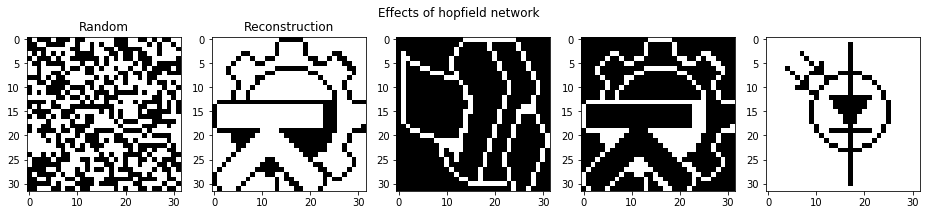

In [173]:
# part 1
for i in range(4):
    random_pattern = np.random.choice([-1,1],size=(1024,))
    recalled_pattern = task.recall(random_pattern, max_iter=100)
    visualise_random_pattern(pictures[:3],random_pattern,recalled_pattern)


Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations


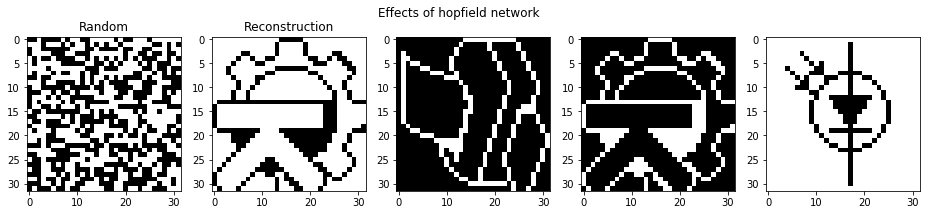

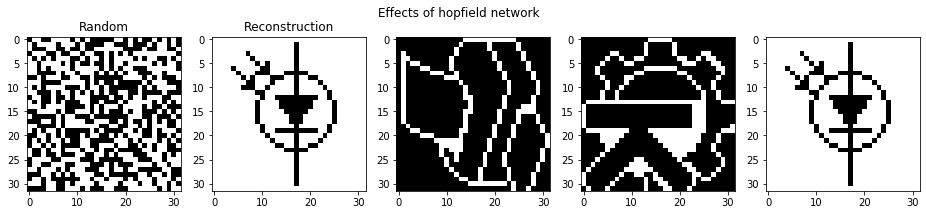

In [146]:
# part 1
for i in range(4):
    random_pattern = np.random.choice([-1,1],size=(1024,))
    recalled_pattern = task.recall(random_pattern, max_iter=100)
    visualise_random_pattern(pictures[:3],random_pattern,recalled_pattern)

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations


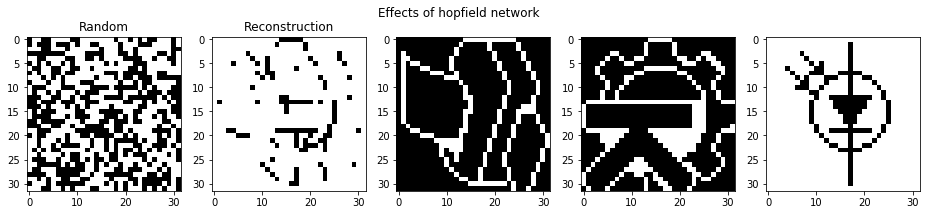

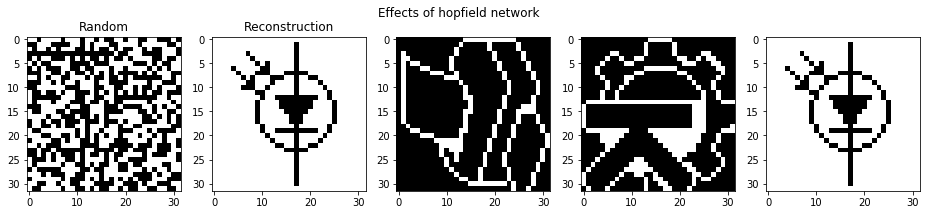

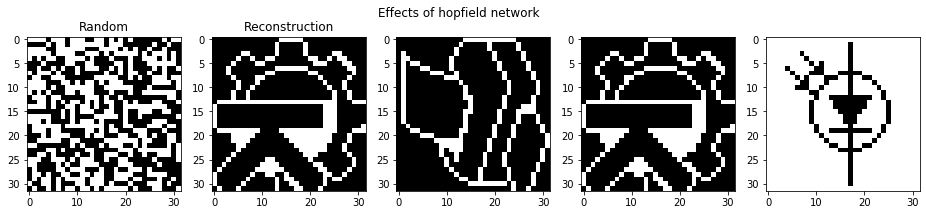

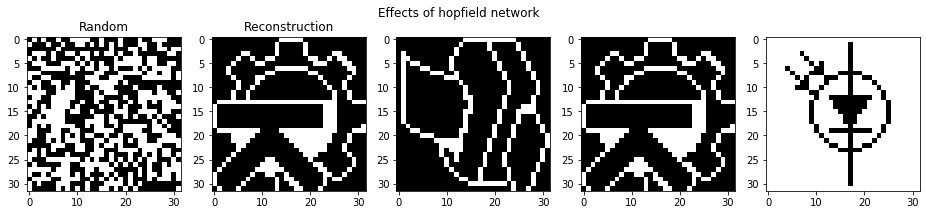

In [147]:
# part 1
for i in range(4):
    random_pattern = np.random.choice([-1,1],size=(1024,))
    recalled_pattern = task.recall(random_pattern, max_iter=100)
    visualise_random_pattern(pictures[:3],random_pattern,recalled_pattern)

Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations
Fixed point reached after 2 iterations


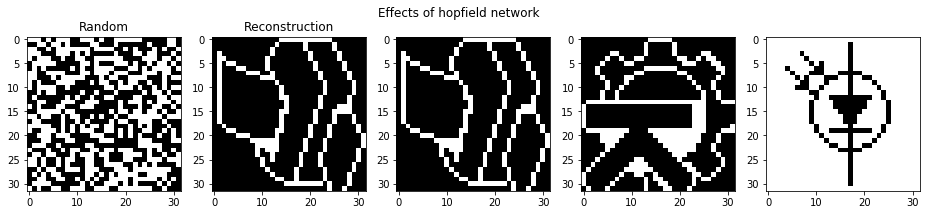

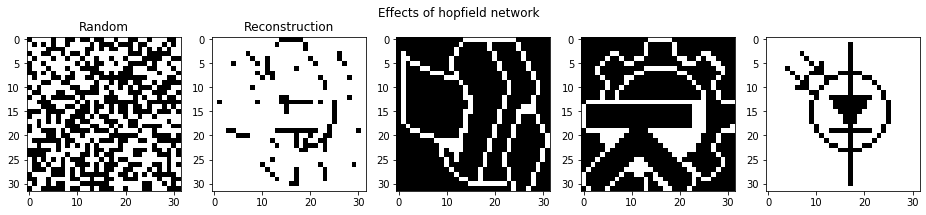

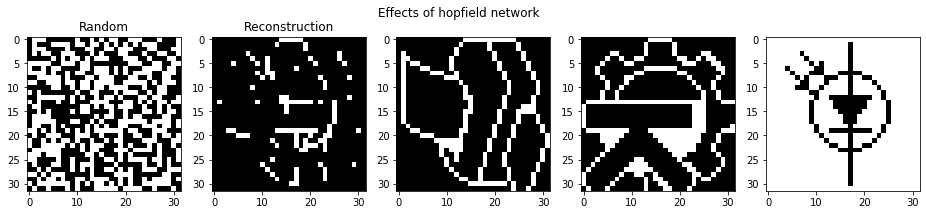

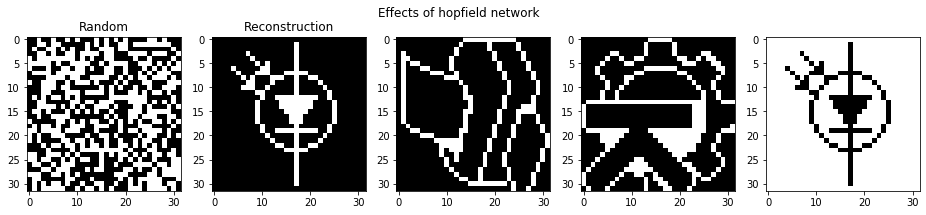

In [148]:
# part 1
for i in range(4):
    random_pattern = np.random.choice([-1,1],size=(1024,))
    recalled_pattern = task.recall(random_pattern, max_iter=100)
    visualise_random_pattern(pictures[:3],random_pattern,recalled_pattern)

In [194]:
# task 3.2c) part 2 - SEQUENTIAL UPDATE
task = hopfield_network(pictures[0:3], update_rule='sequential')

Fixed point reached after 2 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations
Fixed point reached after 3 iterations


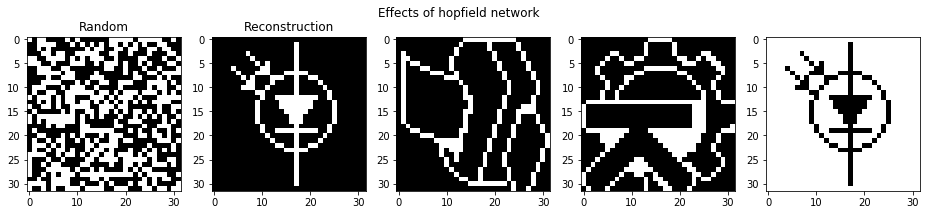

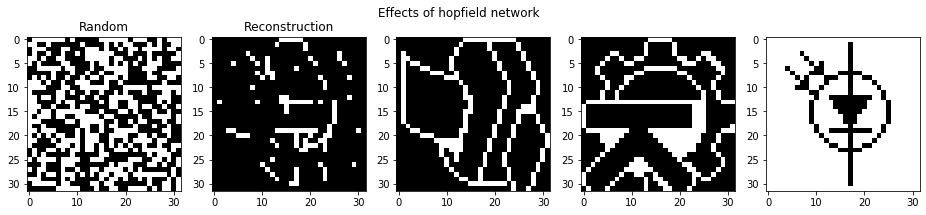

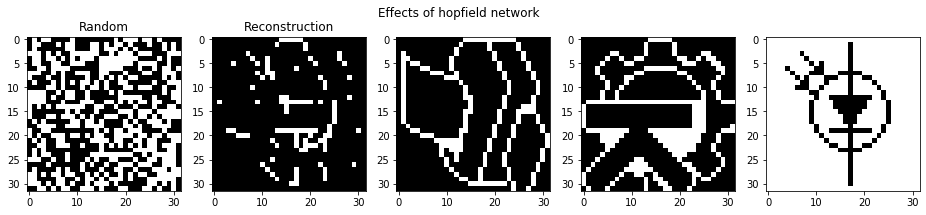

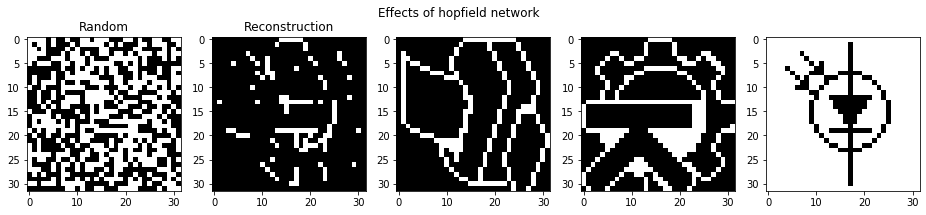

In [198]:
for i in range(4):
    random_pattern = np.random.choice([-1,1],size=(1024,))
    recalled_pattern = task.recall(random_pattern, max_iter=10000)
    visualise_random_pattern(pictures[:3],random_pattern,recalled_pattern)